## Домашнее задание, PyTorch, Кривоногов Н.В.

1. Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv
/kaggle/input/twitter-sentiment-analysis-hatred-speech/test.csv


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

In [3]:
max_words = 2500
max_len = 25
num_classes = 1

# Training
epochs = 5
batch_size = 512
print_batch_n = 100

In [4]:
df = pd.read_csv("/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv")

In [5]:
df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


"label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist"

In [6]:
# наблюдаю сильный дисбаланс классов: 

df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

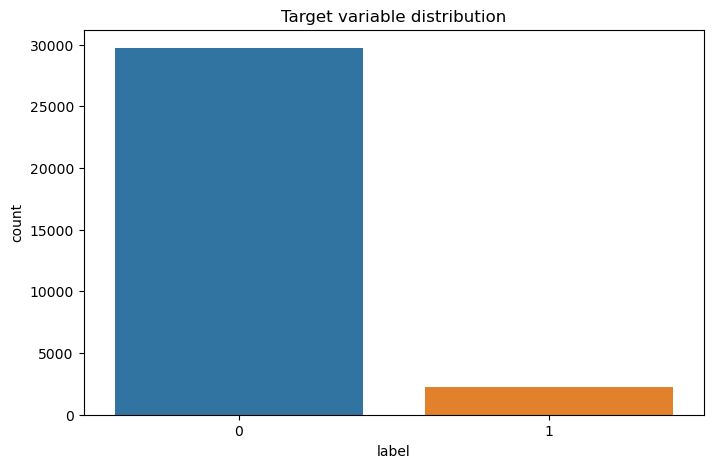

In [7]:
# смотрю распределение целевой переменной label: 

plt.figure(figsize=(8, 5))

sns.countplot(x='label', data=df)

plt.title('Target variable distribution')
plt.show()

In [8]:
# функция балансировки классов: 

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [9]:
# провожу балансировку классов целевой переменной: 

df_for_balancing = df
target_name = 'label'
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

/tmp/ipykernel_1191/838415103.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sample, ignore_index=True)


0    29720
1    29146
Name: label, dtype: int64

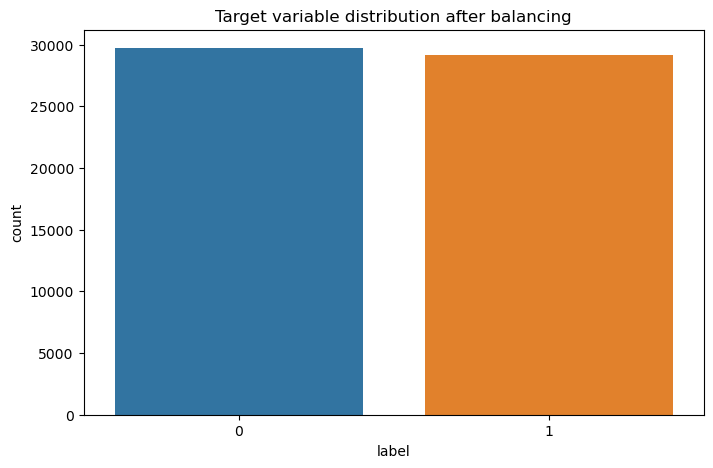

In [10]:
# смотрю распределение целевой переменной после балансировки: 

plt.figure(figsize=(8, 5))

sns.countplot(x=target_name, data=df_balanced)

plt.title('Target variable distribution after balancing')
plt.show()

In [11]:
df_train, df_val = train_test_split(df_balanced, test_size=0.3, random_state=42) #shuffle=True, stratify=df['label'], )

In [12]:
!pip install stop-words pymorphy2

In [13]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [14]:
sw = set(get_stop_words("en"))

sw, len(sw)

({'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  "can't",
  'cannot',
  'could',
  "couldn't",
  'did',
  "didn't",
  'do',
  'does',
  "doesn't",
  'doing',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'had',
  "hadn't",
  'has',
  "hasn't",
  'have',
  "haven't",
  'having',
  'he',
  "he'd",
  "he'll",
  "he's",
  'her',
  'here',
  "here's",
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  "how's",
  'i',
  "i'd",
  "i'll",
  "i'm",
  "i've",
  'if',
  'in',
  'into',
  'is',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  "let's",
  'me',
  'more',
  'most',
  "mustn't",
  'my',
  'myself',
  'no',
  'nor',
  'not',
  'of',
  'off',
  'on',
  'once',
  'only',
  'or',
  'other',
  'ought',
  'our',
  'ours',
  'ourselves',

In [15]:
new_sw = {'im', 'u', 'us', '2', '2016', '4', '2017', 'ive', '3', '1', 'r', 'iam', 's', 'n', '10', 'ur', 'w', '8', '5', 'd', 'shes', '7', 'b', 'ag', 'bc', '6', 'x', '12', 'gt', 'whos', '1st', 'self', '50', 't', 'y'}

sw = sw.union(new_sw) 

sw, len(sw)

({'1',
  '10',
  '12',
  '1st',
  '2',
  '2016',
  '2017',
  '3',
  '4',
  '5',
  '50',
  '6',
  '7',
  '8',
  'a',
  'about',
  'above',
  'after',
  'ag',
  'again',
  'against',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  "aren't",
  'as',
  'at',
  'b',
  'bc',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  "can't",
  'cannot',
  'could',
  "couldn't",
  'd',
  'did',
  "didn't",
  'do',
  'does',
  "doesn't",
  'doing',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'gt',
  'had',
  "hadn't",
  'has',
  "hasn't",
  'have',
  "haven't",
  'having',
  'he',
  "he'd",
  "he'll",
  "he's",
  'her',
  'here',
  "here's",
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  "how's",
  'i',
  "i'd",
  "i'll",
  "i'm",
  "i've",
  'iam',
  'if',
  'im',
  'in',
  'into',
  'is',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  'ive',
  "let's",
  'me',
  'more',
  'm

In [16]:
puncts = set(punctuation)

puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [17]:
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
#     txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [18]:
df_train['tweet'].iloc[:1].values

array(['one powerful picture. it takes great humanity and kindness to save the life of someone who hates your existenceâ\x80¦ '],
      dtype=object)

In [19]:
df_train['tweet'].iloc[:1].apply(preprocess_text).values

array(['one powerful picture takes great humanity kindness save life someone hates existenceâ\x80¦'],
      dtype=object)

In [20]:
from tqdm import tqdm
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 17660/17660 [00:06<00:00, 2905.18it/s]


In [21]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [22]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['one', 'powerful', 'picture', 'takes', 'great']

In [23]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [24]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

2499

In [25]:
tokens_filtered_top[:10]

['user',
 'amp',
 'love',
 'trump',
 'like',
 'day',
 'just',
 'will',
 'people',
 'libtard']

In [26]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

vocabulary

{'user': 1,
 'amp': 2,
 'love': 3,
 'trump': 4,
 'like': 5,
 'day': 6,
 'just': 7,
 'will': 8,
 'people': 9,
 'libtard': 10,
 'white': 11,
 'black': 12,
 'happy': 13,
 'new': 14,
 'can': 15,
 'dont': 16,
 'one': 17,
 'time': 18,
 'politics': 19,
 'get': 20,
 'racist': 21,
 'good': 22,
 'now': 23,
 'cant': 24,
 'might': 25,
 'allahsoil': 26,
 'life': 27,
 'liberal': 28,
 'today': 29,
 'feel': 30,
 'women': 31,
 'go': 32,
 'sjw': 33,
 'see': 34,
 'hate': 35,
 'obama': 36,
 'thankful': 37,
 'want': 38,
 'positive': 39,
 'take': 40,
 'never': 41,
 'got': 42,
 'work': 43,
 'bihday': 44,
 'listen': 45,
 'make': 46,
 'great': 47,
 'retweet': 48,
 'need': 49,
 'youre': 50,
 'racism': 51,
 'think': 52,
 'fathers': 53,
 'via': 54,
 'thanks': 55,
 'world': 56,
 'america': 57,
 'way': 58,
 'girl': 59,
 'back': 60,
 'know': 61,
 'really': 62,
 'smile': 63,
 'man': 64,
 'going': 65,
 'first': 66,
 'stop': 67,
 'much': 68,
 'healthy': 69,
 'year': 70,
 'sad': 71,
 'look': 72,
 'right': 73,
 'stomping

In [27]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [28]:
%%time

x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

CPU times: user 12.4 s, sys: 49.7 ms, total: 12.5 s
Wall time: 12.5 s


In [29]:
x_train.shape

(41206, 25)

In [30]:
df_train['tweet'].iloc[0]

'one powerful picture takes great humanity kindness save life someone hates existenceâ\x80¦'

In [31]:
x_train[0]

array([  17, 1008,  592,  834,   47,  701, 1147,  707,   27,  157, 1177,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)

    def forward(self, x):
        output = self.embedding(x) # B, L, E
        #                       B  E  L
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [33]:
from torch.utils.data import DataLoader, Dataset


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [34]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [35]:
val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [36]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 25])
torch.Size([512])
tensor(0)


In [37]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cpu'

In [38]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(2500, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 410497


In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [40]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

    # выводим статистику о процессе обучения
    model.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

    model.train()

print('Training is finished!')

Epoch [1/5]. Step [81/81]. Loss: 0.255. Acc: 0.786. Test loss: 0.075. Test acc: 0.904
Epoch [2/5]. Step [81/81]. Loss: 0.071. Acc: 0.948. Test loss: 0.016. Test acc: 0.968
Epoch [3/5]. Step [81/81]. Loss: 0.023. Acc: 0.985. Test loss: 0.004. Test acc: 0.981
Epoch [4/5]. Step [81/81]. Loss: 0.062. Acc: 0.994. Test loss: 0.000. Test acc: 0.978
Epoch [5/5]. Step [81/81]. Loss: 0.014. Acc: 0.995. Test loss: 0.001. Test acc: 0.983
Training is finished!


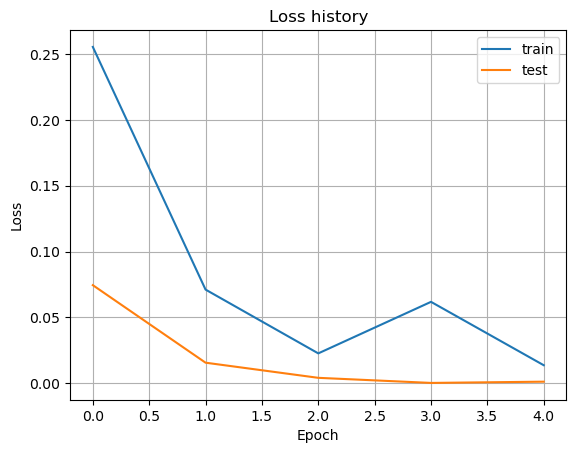

In [41]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

Результат с параметрами видеурока: 

Epoch [5/5]. Step [44/44]. Loss: 0.052. Acc: 0.983. Test loss: 0.006. Test acc: 0.947

Результат после применения функции балансировки классов: 

Epoch [4/5]. Step [81/81]. Loss: 0.012. Acc: 0.992. Test loss: 0.000. Test acc: 0.981

Результат после расширения множества стоп-слов, установления lr = 0.001, max_words = 2500, max_len = 25: 

Epoch [4/5]. Step [81/81]. Loss: 0.019. Acc: 0.993. Test loss: 0.081. Test acc: 0.985